<a href="https://colab.research.google.com/github/brunoodon/mvp_sprintII/blob/main/MVP_Sprint_II(A).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MVP - Machine Learning - Sprint II**

# Definição do problema
É um problema de classificação, com aprendizado supervisionado. Trata-se de um dataset de transações de BitCoin para resgate de arquivos criptografados por Ransomwares.
O objetivo deste modelo é tentar prever o tipo de Ransomware baseado no aprendizado dos dados das transações durante os anos.
## Descrição do dataset:
O Bitcoin Heist Data é um histórico de transações de criptomoedas coletadas com 24 horas de intervalo. Os destinos dessas transações são grupos de criminosos que criptografaram arquivos de vitmas ao redor do mundo via infecção por Ransomwares diversos. Nesse caso, o criminoso emitia uma nota de resgate com o endereço para pagamento do resgate dos arquivos.

**Campos do dataset:**

address: endereço de bitcoin - String;

year: ano da transação - Integer;

day: dia do ano (dias corridos - de 1 a 365) - Integer;

length: Integer;

weight: Float;

count: Integer;

looped: Integer;

neighbors: Integer;

income: quantidade de Satoshis depositados (1 bitcoin = 100 milhões de Satoshis) - Integer;

label(target): família de Ransomware que infectou a vítima. Quando o label é 'White', significa que não foi possível detectar se a transação foi para pagamento de resgate ou não - String.









In [2]:

import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
##importando os módulos da biblioteca sklearn para realizar a modelagem
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#Preparação dos dados

Neste estágio, vamos carregar o dataset, ordenar por ano (mais recente) e tratar os missgins.

In [3]:
#carregando o dataset
url = 'https://raw.githubusercontent.com/brunoodon/mvp_sprintII/main/BitcoinHeistData_MVP.csv'
dataset = pd.read_csv(url).sort_values(by='year', ascending=False)
#Limpando os missings do dataset e fazendo a verificação de que realmente não existem
dataset.dropna(inplace=True)
display(dataset)
missings = dataset.isnull().sum()
display(missings)

,address,year,day,length,weight,count,looped,neighbors,income,label
23628,1F1tAaz5x1HUXrCNLbtMDqcw6o5GNn4xqX,2018,134,140,0.155440,6345,0,1,1.178321e+08,montrealRazy
11756,18JYQBHwyT62QswNfpqX5R4m88v7Q9NyPY,2018,273,2,0.070238,3,0,2,1.162654e+08,montrealFlyper
38100,1P29xxkwy6wvLxJVA2cLoXBri2hZzaweSV,2018,121,0,0.043478,1,0,1,1.099500e+08,montrealFlyper
23657,1F2K3zxpjTWDL7aBt497cVqUJUG3G85rkE,2017,170,0,1.000000,1,0,1,6.000000e+08,montrealSamSam
36376,1MzushH732FkERrXwEWNmoL2aMK3qxWTco,2017,19,6,0.005208,1,0,2,8.000000e+07,princetonCerber
...,...,...,...,...,...,...,...,...,...,...
44376,1GGKELaoz3m4eoUa5rq2f4S8atFVGusrdp,2011,7,16,1.000000,1,0,2,3.290500e+10,white
44375,1AkkyqwUrXgDKyAReEPqky4XsUpygpy5cR,2011,7,4,0.250000,1,0,1,4.100000e+09,white
44374,16EnhfSz2u7tn5c1F6QDiEawAzpZ6M9gyX,2011,7,42,1.000000,1,0,2,9.831000e+09,white
44373,1FAifHZcxdonuWESbc5MBUHq5ncYp9AgEe,2011,7,40,1.000000,1,0,2,9.836000e+09,white


address      0
year         0
day          0
length       0
weight       0
count        0
looped       0
neighbors    0
income       0
label        0
dtype: int64

Para facilitar a análise, vamos fazer uma representação gráfica da distribuição de transações de resgate de arquivos por ano e as respectivas famílias de Ransomwares que causaram o problema.

Importante atentar para o fato de que algumas transações de resgate ocorreram exclusivamente em um ano específico, como o caso da família montrealWannaCry, em 2017.

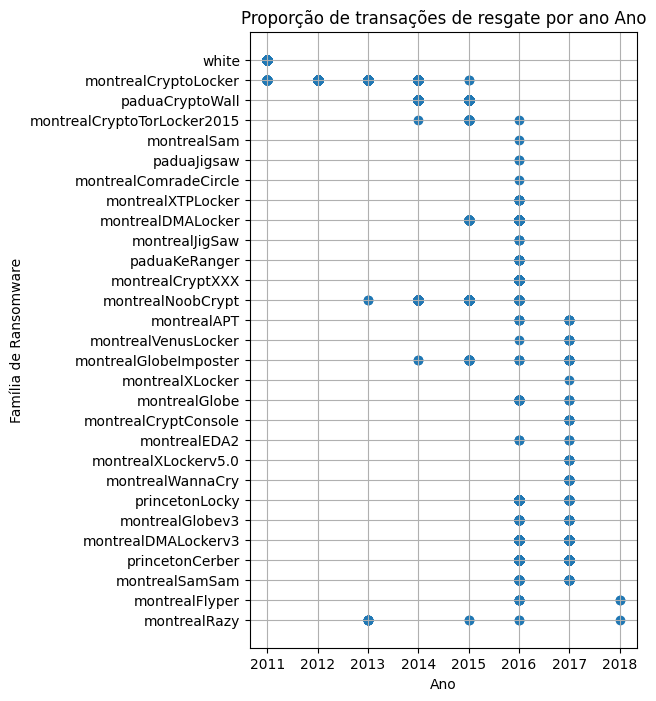

In [4]:
#definindo o dataframe e os eixos para a exibição do gráfico tipo scatter plotter
df = dataset[["year", "label"]]
plt.figure(figsize=(5,8))
y = df['label']
x = df['year']
plt.scatter(x, y)
plt.title("Proporção de transações de resgate por ano Ano")
plt.xlabel("Ano")
plt.ylabel("Família de Ransomware")
plt.grid(True)
plt.show()


# Separação e Transformação dos dados

Aqui, vamos fazer a normalização dos dados e a sepação em conjuntos de Treino e Teste.

In [8]:
#criando um array com os valores do dataset:
array = dataset.values
#definindo os valores de X
X = array[:,1:9]
#Normalizando os dados:
max = np.max(X)
min = np.min(X)
X_norm = (X - min) / (max - min)
#Definindo o 'Target':
y = array[:,9]
#Separando os dados em 80% para treino e 20% para teste
X_norm_train, X_norm_test, y_train, y_test, = train_test_split(X_norm, y, test_size=0.20, random_state=7)
display(X_norm)
#definindo a quantidade de resultados de cross validation que serão avaliados no final (quantidade de partições)
num_particoes = 10
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7)

array([[7.776493256262043e-10, 5.163776493256262e-11,
        5.3949903660886317e-11, ..., 0.0, 3.8535645472061657e-13,
        4.5407351445086704e-05],
       [7.776493256262043e-10, 1.0520231213872832e-10,
        7.707129094412331e-13, ..., 0.0, 7.707129094412331e-13,
        4.480364007707129e-05],
       [7.776493256262043e-10, 4.662813102119461e-11, 0.0, ..., 0.0,
        3.8535645472061657e-13, 4.2369942196531794e-05],
       ...,
       [7.749518304431599e-10, 2.697495183044316e-12,
        1.6184971098265896e-11, ..., 0.0, 7.707129094412331e-13,
        0.0037884393063583816],
       [7.749518304431599e-10, 2.697495183044316e-12,
        1.541425818882466e-11, ..., 0.0, 7.707129094412331e-13,
        0.0037903660886319844],
       [7.749518304431599e-10, 5.7803468208092484e-12,
        3.853564547206165e-12, ..., 0.0, 7.707129094412331e-13,
        0.0017876685934489402]], dtype=object)

# Modelagem

Aqui, vamos definir os modelos e testar a acurácia de cada um deles.

In [ ]:

np.random.seed(7)
#Criando uma lista vazia de modelos, resultados e nomes
models = []
results = []
names = []
#Fazendo append na lista de modelos que serão avaliados
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

#Para cada label e modelo, executar a validação cruzada no conjunto de treino, definindo como método de avaliação a acurácia
for name, model in models:
  cv_results = cross_val_score(model, X_norm_train, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) # média e desvio padrão dos 10 resultados da validação cruzada
  print(msg)

# Comparação da acurácia dos modelos
fig = plt.figure()
fig.suptitle('Comparação da Acurácia dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


LR: 0.247392 (0.006530)
KNN: 0.649117 (0.008634)
CART: 0.474963 (0.012146)
NB: 0.275712 (0.007642)


Como o algorítmo que obteve a melhor acurácia foi o K Nearest Neighbors, vamos utilzá-lo para criar um modelo

In [7]:
#usando o conjunto de treino normalizado para criar o modelo
model = KNeighborsClassifier()
model.fit(X_norm_train, y_train)
#usando o conjunto de teste para realizar as predições
predictions = model.predict(X_norm_test)
#calculando a acurácia das predições
print(accuracy_score(y_test, predictions))

0.6593003666633634


Observa-se que os indicadores de acurácia dos conjuntos de treino e teste são bem próximos.